## 🔍 Đánh giá Chất lượng Dữ liệu (Data Quality Assessment)

Phần này sẽ đánh giá chất lượng của các bộ dữ liệu đã thu thập theo các tiêu chí:

### 📊 Các tiêu chí đánh giá:
1. **Completeness (Tính đầy đủ)**: Phần trăm dữ liệu thiếu, gaps trong time series
2. **Accuracy (Tính chính xác)**: Outliers, giá trị bất thường
3. **Consistency (Tính nhất quán)**: Định dạng, đơn vị, quy ước
4. **Validity (Tính hợp lệ)**: Phạm vi giá trị, ràng buộc nghiệp vụ
5. **Uniqueness (Tính duy nhất)**: Duplicate records
6. **Timeliness (Tính kịp thời)**: Tần suất cập nhật, độ trễ dữ liệu


In [ ]:
# Class đánh giá chất lượng dữ liệu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class DataQualityAssessment:
    def __init__(self):
        """
        Khởi tạo class đánh giá chất lượng dữ liệu
        """
        self.quality_report = {}

    def assess_dataset(self, df: pd.DataFrame, dataset_name: str,
                      time_col: str = 'period', value_cols: list = None) -> dict:
        """
        Đánh giá tổng thể chất lượng dữ liệu

        Args:
            df: DataFrame cần đánh giá
            dataset_name: Tên bộ dữ liệu
            time_col: Tên cột thời gian
            value_cols: Danh sách cột giá trị quan trọng

        Returns:
            Dictionary chứa kết quả đánh giá
        """

        print(f"🔍 ĐÁNH GIÁ CHẤT LƯỢNG DỮ LIỆU: {dataset_name.upper()}")
        print("=" * 80)

        if df.empty:
            print("❌ Dataset rỗng!")
            return {}

        # Khởi tạo báo cáo
        report = {
            'dataset_name': dataset_name,
            'total_records': len(df),
            'total_columns': len(df.columns),
            'assessment_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        # 1. Đánh giá cơ bản
        print("📊 1. THÔNG TIN CỞ BẢN:")
        basic_info = self.assess_basic_info(df)
        report['basic_info'] = basic_info

        # 2. Đánh giá tính đầy đủ (Completeness)
        print("\\n📋 2. TÍNH ĐẦY ĐỦ (COMPLETENESS):")
        completeness = self.assess_completeness(df)
        report['completeness'] = completeness

        # 3. Đánh giá tính nhất quán (Consistency)
        print("\\n🔄 3. TÍNH NHẤT QUÁN (CONSISTENCY):")
        consistency = self.assess_consistency(df, time_col)
        report['consistency'] = consistency

        # 4. Đánh giá tính hợp lệ (Validity)
        print("\\n✅ 4. TÍNH HỢP LỆ (VALIDITY):")
        validity = self.assess_validity(df, value_cols)
        report['validity'] = validity

        # 5. Đánh giá tính duy nhất (Uniqueness)
        print("\\n🔢 5. TÍNH DUY NHẤT (UNIQUENESS):")
        uniqueness = self.assess_uniqueness(df, time_col)
        report['uniqueness'] = uniqueness

        # 6. Đánh giá tính chính xác (Accuracy) - Outliers
        print("\\n🎯 6. TÍNH CHÍNH XÁC (ACCURACY - OUTLIERS):")
        accuracy = self.assess_accuracy(df, value_cols)
        report['accuracy'] = accuracy

        # 7. Đánh giá tính kịp thời (Timeliness)
        if time_col in df.columns and pd.api.types.is_datetime64_any_dtype(df[time_col]):
            print("\\n⏰ 7. TÍNH KỊP THỜI (TIMELINESS):")
            timeliness = self.assess_timeliness(df, time_col)
            report['timeliness'] = timeliness

        # 8. Tổng kết điểm chất lượng
        print("\\n🏆 8. TỔNG KẾT ĐIỂM CHẤT LƯỢNG:")
        overall_score = self.calculate_overall_score(report)
        report['overall_score'] = overall_score

        self.quality_report[dataset_name] = report

        print("=" * 80)
        return report

    def assess_basic_info(self, df: pd.DataFrame) -> dict:
        """Đánh giá thông tin cơ bản"""
        info = {
            'shape': df.shape,
            'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024 / 1024,
            'columns': df.columns.tolist(),
            'dtypes': df.dtypes.to_dict()
        }

        print(f"   📏 Kích thước: {info['shape'][0]:,} hàng × {info['shape'][1]} cột")
        print(f"   💾 Bộ nhớ: {info['memory_usage_mb']:.2f} MB")
        print(f"   📋 Các cột: {len(info['columns'])} cột")

        return info

    def assess_completeness(self, df: pd.DataFrame) -> dict:
        """Đánh giá tính đầy đủ của dữ liệu theo tiêu chuẩn Data Quality"""
        # 1. Tính missing values cơ bản
        missing_data = df.isnull().sum()
        missing_percent = (missing_data / len(df) * 100).round(2)

        # 2. Completeness theo Object (từng cột)
        completeness_by_column = {}
        for col in df.columns:
            valid_values = df[col].notna().sum()
            total_values = len(df)
            completeness_ratio = (valid_values / total_values) * 100
            completeness_by_column[col] = {
                'valid_count': valid_values,
                'total_count': total_values,
                'completeness_ratio': round(completeness_ratio, 2),
                'missing_count': total_values - valid_values
            }

        # 3. Completeness trên toàn bộ dữ liệu
        total_cells = df.shape[0] * df.shape[1]
        total_valid_cells = df.notna().sum().sum()
        total_missing_cells = total_cells - total_valid_cells
        overall_completeness = (total_valid_cells / total_cells) * 100

        # 4. Tính độ đầy đủ theo hàng (row-wise completeness)
        row_completeness = []
        for idx in range(len(df)):
            row_valid = df.iloc[idx].notna().sum()
            row_total = len(df.columns)
            row_comp = (row_valid / row_total) * 100
            row_completeness.append(row_comp)

        avg_row_completeness = np.mean(row_completeness)

        # 5. Phân loại mức độ thiếu dữ liệu
        completeness_categories = {
            'excellent': 0,  # >95%
            'good': 0,       # 80-95%
            'fair': 0,       # 60-80%
            'poor': 0        # <60%
        }

        for col, stats in completeness_by_column.items():
            ratio = stats['completeness_ratio']
            if ratio > 95:
                completeness_categories['excellent'] += 1
            elif ratio >= 80:
                completeness_categories['good'] += 1
            elif ratio >= 60:
                completeness_categories['fair'] += 1
            else:
                completeness_categories['poor'] += 1

        completeness = {
            # Completeness cơ bản
            'missing_values': missing_data.to_dict(),
            'missing_percent': missing_percent.to_dict(),
            'complete_rows': len(df.dropna()),
            'complete_rows_percent': (len(df.dropna()) / len(df) * 100),

            # Completeness theo Object (cột)
            'completeness_by_column': completeness_by_column,
            'column_completeness_summary': {
                'avg_completeness': np.mean([stats['completeness_ratio'] for stats in completeness_by_column.values()]),
                'min_completeness': min([stats['completeness_ratio'] for stats in completeness_by_column.values()]),
                'max_completeness': max([stats['completeness_ratio'] for stats in completeness_by_column.values()])
            },

            # Completeness trên toàn bộ dữ liệu
            'overall_completeness': {
                'total_cells': total_cells,
                'valid_cells': total_valid_cells,
                'missing_cells': total_missing_cells,
                'completeness_ratio': round(overall_completeness, 2)
            },

            # Row-wise completeness
            'row_completeness': {
                'average': round(avg_row_completeness, 2),
                'distribution': {
                    'complete_rows_100%': sum(1 for x in row_completeness if x == 100),
                    'rows_90_99%': sum(1 for x in row_completeness if 90 <= x < 100),
                    'rows_75_89%': sum(1 for x in row_completeness if 75 <= x < 90),
                    'rows_below_75%': sum(1 for x in row_completeness if x < 75)
                }
            },

            # Phân loại chất lượng
            'quality_categories': completeness_categories,

            # Điểm completeness tổng thể (0-100)
            'completeness_score': round(overall_completeness, 2)
        }

        # In kết quả chi tiết
        print(f"   📊 COMPLETENESS ASSESSMENT:")
        print(f"      🔍 Completeness trên toàn bộ dữ liệu: {completeness['overall_completeness']['completeness_ratio']:.2f}%")
        print(f"      📋 Hàng hoàn chỉnh 100%: {completeness['complete_rows']:,}/{len(df):,} ({completeness['complete_rows_percent']:.1f}%)")
        print(f"      📈 Trung bình completeness theo cột: {completeness['column_completeness_summary']['avg_completeness']:.2f}%")
        print(f"      📊 Trung bình completeness theo hàng: {completeness['row_completeness']['average']:.2f}%")

        print(f"\\n   📂 PHÂN LOẠI CHẤT LƯỢNG CỘT:")
        print(f"      ✅ Excellent (>95%): {completeness_categories['excellent']} cột")
        print(f"      🟢 Good (80-95%): {completeness_categories['good']} cột")
        print(f"      🟡 Fair (60-80%): {completeness_categories['fair']} cột")
        print(f"      🔴 Poor (<60%): {completeness_categories['poor']} cột")

        # Hiển thị top cột thiếu dữ liệu
        missing_cols = missing_percent[missing_percent > 0].sort_values(ascending=False)
        if not missing_cols.empty:
            print(f"\\n   ⚠️ TOP CỘT THIẾU DỮ LIỆU:")
            for col, percent in missing_cols.head().items():
                print(f"      - {col}: {percent}% thiếu")
        else:
            print(f"\\n   ✅ KHÔNG CÓ DỮ LIỆU THIẾU!")

        return completeness

    def assess_consistency(self, df: pd.DataFrame, time_col: str = 'period') -> dict:
        """Đánh giá tính nhất quán của dữ liệu"""
        consistency = {
            'data_types': {},
            'time_gaps': [],
            'format_issues': [],
            'consistency_rules': {},
            'cross_column_consistency': {},
            'pattern_consistency': {},
            'consistency_score': 0
        }

        total_consistency_checks = 0
        passed_consistency_checks = 0

        print(f"   🔄 CONSISTENCY ASSESSMENT:")

        # 1. Kiểm tra data types consistency
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        text_cols = df.select_dtypes(include=['object', 'category']).columns.tolist() # Include category
        datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

        consistency['data_types'] = {
            'numeric_count': len(numeric_cols),
            'text_count': len(text_cols),
            'datetime_count': len(datetime_cols),
            'total_columns': len(df.columns),
            'numeric_cols': numeric_cols,
            'text_cols': text_cols,
            'datetime_cols': datetime_cols
        }

        print(f"      📊 Phân bố kiểu dữ liệu:")
        print(f"         - Số: {len(numeric_cols)} cột")
        print(f"         - Văn bản: {len(text_cols)} cột")
        print(f"         - Thời gian: {len(datetime_cols)} cột")

        # 2. Kiểm tra tính nhất quán của format trong text columns
        format_consistency_issues = []
        for col in text_cols:
            if col in df.columns and df[col].notna().sum() > 0:
                # Kiểm tra pattern consistency (ví dụ: date format, ID format)
                unique_patterns = set()
                sample_values = df[col].dropna().astype(str).head(100)

                for val in sample_values:
                    # Tạo pattern đơn giản dựa trên độ dài và ký tự
                    pattern = ''
                    for char in val:
                        if char.isdigit():
                            pattern += 'D'
                        elif char.isalpha():
                            pattern += 'A'
                        elif char in ['-', '/', '_', ':', ' ']:
                            pattern += char
                        else:
                            pattern += 'S'
                    unique_patterns.add(pattern)

                pattern_consistency = len(unique_patterns)
                consistency['pattern_consistency'][col] = {
                    'unique_patterns': len(unique_patterns),
                    'total_samples': len(sample_values),
                    'consistency_ratio': (1 / len(unique_patterns)) * 100 if len(unique_patterns) > 0 else 100
                }

                # Consider columns with many unique patterns as having potential format issues
                if len(unique_patterns) > 10: # Increased threshold for more robustness
                     format_consistency_issues.append(f"Column '{col}' có {len(unique_patterns)} patterns khác nhau")


        consistency['format_issues'] = format_consistency_issues

        # 3. Kiểm tra time gaps và time consistency
        if time_col in df.columns and pd.api.types.is_datetime64_any_dtype(df[time_col]):
            time_gaps = self.check_time_gaps(df, time_col)
            consistency['time_gaps'] = time_gaps

            # Thêm kiểm tra time consistency
            time_series = df[time_col].dropna().sort_values()
            if len(time_series) > 1:
                time_diffs = time_series.diff().dropna()

                # Tính consistency của time intervals
                if not time_diffs.empty:
                    most_common_interval = time_diffs.mode().iloc[0] if not time_diffs.mode().empty else None
                    consistent_intervals = (time_diffs == most_common_interval).sum() if most_common_interval else 0
                    total_intervals = len(time_diffs)
                    time_consistency_ratio = (consistent_intervals / total_intervals * 100) if total_intervals > 0 else 0

                    consistency['time_consistency'] = {
                        'most_common_interval': str(most_common_interval),
                        'consistent_intervals': consistent_intervals,
                        'total_intervals': total_intervals,
                        'consistency_ratio': round(time_consistency_ratio, 2)
                    }

                    total_consistency_checks += 1
                    if time_consistency_ratio >= 80:
                        passed_consistency_checks += 1

            if time_gaps:
                print(f"         ⚠️ Phát hiện {len(time_gaps)} khoảng trống thời gian")
            else:
                print(f"         ✅ Không có khoảng trống thời gian")
                total_consistency_checks += 1
                passed_consistency_checks += 1


        # 4. Cross-column consistency checks
        cross_column_issues = []

        # Kiểm tra logical consistency giữa các cột
        # Re-evaluate energy_cols based on numeric type
        energy_cols = [col for col in numeric_cols if any(keyword in col.lower()
                          for keyword in ['value', 'demand', 'generation', 'consumption'])]


        for col in energy_cols:
            if col in df.columns and df[col].dtype in ['int64', 'float64']:
                negative_count = (df[col] < 0).sum()
                total_values = df[col].notna().sum()

                if total_values > 0:
                    negative_ratio = (negative_count / total_values) * 100
                    consistency['cross_column_consistency'][f'{col}_negative_check'] = {
                        'negative_count': negative_count,
                        'total_values': total_values,
                        'negative_ratio': round(negative_ratio, 2),
                        'is_consistent': negative_ratio < 5  # Cho phép <5% negative
                    }

                    total_consistency_checks += 1
                    if negative_ratio < 5:
                        passed_consistency_checks += 1
                    else:
                        cross_column_issues.append(f"Column '{col}' có {negative_ratio:.1f}% giá trị âm")

        consistency['cross_column_issues'] = cross_column_issues # Store issues

        # 5. Kiểm tra unique constraints và business rules
        business_rule_checks = []

        # Ví dụ: Kiểm tra duplicate trong primary key columns
        potential_key_cols = [col for col in df.columns if any(keyword in col.lower()
                             for keyword in ['id', 'code', 'respondent'])]

        for col in potential_key_cols:
            if col in df.columns:
                duplicates = df[col].duplicated().sum()
                total_records = len(df)
                duplicate_ratio = (duplicates / total_records) * 100

                consistency['consistency_rules'][f'{col}_uniqueness'] = {
                    'duplicates': duplicates,
                    'total_records': total_records,
                    'duplicate_ratio': round(duplicate_ratio, 2),
                    'is_consistent': duplicates == 0 # Strict uniqueness
                }

                total_consistency_checks += 1
                if duplicates == 0:
                    passed_consistency_checks += 1
                else:
                    business_rule_checks.append(f"Column '{col}' có {duplicates} giá trị trùng lặp")

        consistency['business_rule_issues'] = business_rule_checks

        # 6. Tính điểm consistency tổng thể
        if total_consistency_checks > 0:
            consistency_score = (passed_consistency_checks / total_consistency_checks) * 100
        else:
            consistency_score = 100  # Nếu không có checks nào thì coi như consistent

        consistency['consistency_score'] = round(consistency_score, 2)
        consistency['total_checks'] = total_consistency_checks
        consistency['passed_checks'] = passed_consistency_checks

        # In kết quả tổng hợp
        print(f"      📋 Tổng quan tính nhất quán:")
        print(f"         - Điểm consistency: {consistency_score:.2f}%")
        print(f"         - Checks passed: {passed_consistency_checks}/{total_consistency_checks}")

        if format_consistency_issues:
            print(f"         ⚠️ Format issues: {len(format_consistency_issues)}")
            for issue in format_consistency_issues[:2]:  # Show top 2
                print(f"            - {issue}")

        if cross_column_issues:
            print(f"         ⚠️ Cross-column issues: {len(cross_column_issues)}")
            for issue in cross_column_issues[:2]:  # Show top 2
                print(f"            - {issue}")

        if business_rule_checks:
            print(f"         ⚠️ Business rule violations: {len(business_rule_checks)}")
            for issue in business_rule_checks[:2]:  # Show top 2
                print(f"            - {issue}")

        if not format_consistency_issues and not cross_column_issues and not business_rule_checks:
            print(f"         ✅ Không phát hiện vấn đề consistency nghiêm trọng")


        return consistency


    def assess_validity(self, df: pd.DataFrame, value_cols: list = None) -> dict:
        """Đánh giá tính hợp lệ"""
        validity = {
            'negative_values': {},
            'zero_values': {},
            'extreme_values': {},
            'invalid_ranges': {}
        }

        # Ensure value_cols are numeric
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if value_cols is None:
            value_cols = numeric_cols
        else:
            value_cols = [col for col in value_cols if col in numeric_cols]


        for col in value_cols:
            if col in df.columns:
                # Kiểm tra giá trị âm (có thể không hợp lệ với một số metrics)
                negative_count = (df[col] < 0).sum()
                validity['negative_values'][col] = negative_count

                # Kiểm tra giá trị 0
                zero_count = (df[col] == 0).sum()
                validity['zero_values'][col] = zero_count

                # Kiểm tra giá trị cực đoan (> 3 standard deviations)
                if df[col].std() > 0:
                    mean_val = df[col].mean()
                    std_val = df[col].std()
                    extreme_count = ((df[col] - mean_val).abs() > 3 * std_val).sum()
                    validity['extreme_values'][col] = extreme_count

        # In kết quả
        total_negative = sum(validity['negative_values'].values())
        total_zero = sum(validity['zero_values'].values())
        total_extreme = sum(validity['extreme_values'].values())

        print(f"   📊 Tổng quan tính hợp lệ:")
        print(f"      - Giá trị âm: {total_negative:,}")
        print(f"      - Giá trị 0: {total_zero:,}")
        print(f"      - Giá trị cực đoan: {total_extreme:,}")

        return validity

    def assess_uniqueness(self, df: pd.DataFrame, time_col: str = 'period') -> dict:
        """Đánh giá tính duy nhất"""
        uniqueness = {
            'total_duplicates': 0,
            'duplicate_percent': 0,
            'time_duplicates': 0
        }

        # Kiểm tra duplicate toàn bộ
        total_duplicates = df.duplicated().sum()
        uniqueness['total_duplicates'] = total_duplicates
        uniqueness['duplicate_percent'] = (total_duplicates / len(df) * 100) if len(df) > 0 else 0

        print(f"   📊 Bản ghi trùng lặp: {total_duplicates:,} ({uniqueness['duplicate_percent']:.2f}%)")

        # Kiểm tra duplicate theo thời gian
        if time_col in df.columns:
            time_duplicates = df[time_col].duplicated().sum()
            uniqueness['time_duplicates'] = time_duplicates
            print(f"   📅 Thời gian trùng lặp: {time_duplicates:,}")

        return uniqueness

    def assess_accuracy(self, df: pd.DataFrame, value_cols: list = None) -> dict:
        """Đánh giá tính chính xác thông qua phân tích thống kê và outliers"""
        accuracy = {
            'outliers_iqr': {},
            'outliers_zscore': {},
            'data_quality_issues': [],
            'statistical_measures': {},
            'accuracy_metrics': {},
            'correlation_analysis': {} # Initialize correlation_analysis
        }

        # Ensure value_cols are numeric
        numeric_cols_in_df = df.select_dtypes(include=[np.number]).columns.tolist()
        if value_cols is None:
            value_cols_to_assess = numeric_cols_in_df
        else:
            value_cols_to_assess = [col for col in value_cols if col in numeric_cols_in_df]


        total_outliers_iqr = 0
        total_outliers_zscore = 0
        total_data_points = 0 # Track total data points assessed


        print(f"   🎯 ACCURACY ASSESSMENT:")

        # 1. Phân tích outliers và tính tỷ lệ dữ liệu chính xác
        for col in value_cols_to_assess:
            if col in df.columns and df[col].notna().sum() > 0:
                col_data = df[col].dropna()
                total_data_points += len(col_data) # Add to total

                # IQR method để phát hiện outliers
                Q1 = col_data.quantile(0.25)
                Q3 = col_data.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                outliers_iqr = ((col_data < lower_bound) | (col_data > upper_bound)).sum()
                accuracy['outliers_iqr'][col] = outliers_iqr
                total_outliers_iqr += outliers_iqr

                # Z-score method (|z| > 3)
                if col_data.std() > 0:
                    z_scores = np.abs((col_data - col_data.mean()) / col_data.std())
                    outliers_zscore = (z_scores > 3).sum()
                    accuracy['outliers_zscore'][col] = outliers_zscore
                    total_outliers_zscore += outliers_zscore

                # 2. Tính các độ đo thống kê cho từng cột
                accuracy['statistical_measures'][col] = {
                    'mean': col_data.mean(),
                    'median': col_data.median(),
                    'std': col_data.std(),
                    'variance': col_data.var(),
                    'skewness': col_data.skew(),
                    'kurtosis': col_data.kurtosis(),
                    'coefficient_of_variation': (col_data.std() / col_data.mean() * 100) if col_data.mean() != 0 else np.nan,
                    'range': col_data.max() - col_data.min(),
                    'iqr': IQR
                }

                # 3. Tính tỷ lệ dữ liệu chính xác (không phải outliers)
                accurate_data_iqr = len(col_data) - outliers_iqr
                accurate_data_zscore = len(col_data) - outliers_zscore

                accuracy_ratio_iqr = (accurate_data_iqr / len(col_data)) * 100 if len(col_data) > 0 else 100
                accuracy_ratio_zscore = (accurate_data_zscore / len(col_data)) * 100 if len(col_data) > 0 else 100

                accuracy['accuracy_metrics'][col] = {
                    'total_values': len(col_data),
                    'accurate_values_iqr': accurate_data_iqr,
                    'accurate_values_zscore': accurate_data_zscore,
                    'accuracy_ratio_iqr': round(accuracy_ratio_iqr, 2),
                    'accuracy_ratio_zscore': round(accuracy_ratio_zscore, 2),
                    'outlier_ratio_iqr': round((outliers_iqr / len(col_data)) * 100, 2) if len(col_data) > 0 else 0,
                    'outlier_ratio_zscore': round((outliers_zscore / len(col_data)) * 100, 2) if len(col_data) > 0 else 0
                }

        # 4. Phân tích tương quan giữa các cột số
        # Only calculate correlation if there are at least 2 numeric columns in the assessed value_cols
        if len(value_cols_to_assess) >= 2:
            try:
                correlation_matrix = df[value_cols_to_assess].corr()

                # Find pairs with high correlation (can indicate redundancy or dependency)
                high_correlations = []
                # Use unique pairs only
                for i in range(len(correlation_matrix.columns)):
                    for j in range(i+1, len(correlation_matrix.columns)):
                        corr_value = correlation_matrix.iloc[i, j]
                        if pd.notna(corr_value) and abs(corr_value) > 0.7:  # High correlation
                            high_correlations.append({
                                'col1': correlation_matrix.columns[i],
                                'col2': correlation_matrix.columns[j],
                                'correlation': round(corr_value, 3)
                            })

                # Calculate average correlation safely
                upper_triangular_corr = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
                avg_correlation = np.nanmean(upper_triangular_corr) if len(upper_triangular_corr) > 0 else np.nan


                accuracy['correlation_analysis'] = {
                    'correlation_matrix': correlation_matrix.round(3).to_dict(),
                    'high_correlations': high_correlations,
                    'avg_correlation': round(avg_correlation, 3) if pd.notna(avg_correlation) else 'N/A'
                }
            except Exception as e:
                 print(f"   ⚠️ Lỗi khi tính tương quan: {e}")
                 accuracy['correlation_analysis'] = {'error': str(e)} # Store error if calculation fails


        # 5. Tính điểm accuracy tổng thể
        # Use total_data_points calculated earlier
        total_accurate_iqr = sum(accuracy['accuracy_metrics'][col]['accurate_values_iqr']
                                for col in accuracy['accuracy_metrics'])
        total_accurate_zscore = sum(accuracy['accuracy_metrics'][col]['accurate_values_zscore']
                                   for col in accuracy['accuracy_metrics'])

        overall_accuracy_iqr = (total_accurate_iqr / total_data_points * 100) if total_data_points > 0 else 0
        overall_accuracy_zscore = (total_accurate_zscore / total_data_points * 100) if total_data_points > 0 else 0

        accuracy['overall_accuracy'] = {
            'accuracy_ratio_iqr': round(overall_accuracy_iqr, 2),
            'accuracy_ratio_zscore': round(overall_accuracy_zscore, 2),
            'total_outliers_iqr': total_outliers_iqr,
            'total_outliers_zscore': total_outliers_zscore,
            'outlier_percentage_iqr': round((total_outliers_iqr / total_data_points * 100), 2) if total_data_points > 0 else 0,
            'outlier_percentage_zscore': round((total_outliers_zscore / total_data_points * 100), 2) if total_data_points > 0 else 0
        }

        # In kết quả
        print(f"      📊 Tỷ lệ dữ liệu chính xác (IQR method): {overall_accuracy_iqr:.2f}%")
        print(f"      📊 Tỷ lệ dữ liệu chính xác (Z-score method): {overall_accuracy_zscore:.2f}%")
        print(f"      🔍 Tổng outliers phát hiện:")
        print(f"         - IQR method: {total_outliers_iqr:,} ({accuracy['overall_accuracy']['outlier_percentage_iqr']:.2f}%)")
        print(f"         - Z-score method: {total_outliers_zscore:,} ({accuracy['overall_accuracy']['outlier_percentage_zscore']:.2f}%)")


        # Safely print correlation analysis result
        if 'correlation_analysis' in accuracy and 'high_correlations' in accuracy['correlation_analysis']:
            high_correlations_list = accuracy['correlation_analysis']['high_correlations']
            if high_correlations_list:
                print(f"      🔗 Tương quan cao phát hiện: {len(high_correlations_list)} cặp")
                for corr in high_correlations_list[:3]:  # Show top 3
                    print(f"         - {corr['col1']} ↔ {corr['col2']}: {corr['correlation']}")
            else:
                print(f"      ✅ Không phát hiện tương quan cao giữa các cột giá trị.")
        elif 'correlation_analysis' in accuracy and 'error' in accuracy['correlation_analysis']:
             print(f"      ⚠️ Không thể hiển thị tương quan do lỗi: {accuracy['correlation_analysis']['error']}")
        else:
             print(f"      ℹ️ Phân tích tương quan không khả dụng (cần ít nhất 2 cột số).")


        # Assess and print Coefficient of Variation
        if accuracy['statistical_measures']:
            cv_values = [stats['coefficient_of_variation']
                         for stats in accuracy['statistical_measures'].values()
                         if 'coefficient_of_variation' in stats and pd.notna(stats['coefficient_of_variation'])]

            if cv_values:
                avg_cv = np.mean(cv_values)
                print(f"      📏 Hệ số biến thiên trung bình: {avg_cv:.2f}%")

                if avg_cv > 50:
                    print(f"         ⚠️ Dữ liệu có độ biến thiên cao")
                elif avg_cv > 20:
                    print(f"         🟡 Dữ liệu có độ biến thiên trung bình")
                else:
                    print(f"         ✅ Dữ liệu có độ biến thiên thấp")
            else:
                print(f"      ℹ️ Hệ số biến thiên không thể tính toán.")


        return accuracy


    def assess_timeliness(self, df: pd.DataFrame, time_col: str) -> dict:
        """Đánh giá tính kịp thời"""
        timeliness = {
            'date_range': {},
            'frequency': {},
            'gaps': []
        }

        if time_col not in df.columns or not pd.api.types.is_datetime64_any_dtype(df[time_col]):
             print(f"   ℹ️ Cột thời gian '{time_col}' không tồn tại hoặc không ở định dạng datetime.")
             return timeliness


        # Chuyển đổi sang datetime nếu cần (đã làm ở assess_dataset nhưng double check)
        time_series = pd.to_datetime(df[time_col].dropna()).sort_values()

        if time_series.empty:
             print(f"   ℹ️ Cột thời gian '{time_col}' không có giá trị hợp lệ.")
             return timeliness


        # Phạm vi thời gian
        min_date = time_series.min()
        max_date = time_series.max()
        date_range_days = (max_date - min_date).days
        date_range_str = f"{min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}"


        timeliness['date_range'] = {
            'start': min_date.strftime('%Y-%m-%d'),
            'end': max_date.strftime('%Y-%m-%d'),
            'total_days': date_range_days
        }

        print(f"   📅 Phạm vi thời gian: {date_range_str}")
        print(f"   📏 Tổng số ngày: {date_range_days:,} ngày")


        # Phân tích tần suất
        time_diff = time_series.diff().dropna()
        if not time_diff.empty:
            most_common_freq = time_diff.mode().iloc[0] if not time_diff.mode().empty else None
            timeliness['frequency'] = {
                'most_common': str(most_common_freq) if most_common_freq else 'N/A',
                'unique_intervals': len(time_diff.unique())
            }
            if most_common_freq:
                print(f"   ⏱️ Tần suất phổ biến: {most_common_freq}")
            else:
                 print(f"   ℹ️ Không thể xác định tần suất phổ biến.")
        else:
             print(f"   ℹ️ Không đủ dữ liệu để phân tích tần suất.")


        # Check for gaps (using the existing method)
        gaps = self.check_time_gaps(df, time_col)
        timeliness['gaps'] = gaps
        if gaps:
             print(f"   ⚠️ Phát hiện {len(gaps)} khoảng trống thời gian (ngày thiếu).")
        else:
             print(f"   ✅ Không có khoảng trống thời gian đáng kể (ngày thiếu).")


        return timeliness

    def check_time_gaps(self, df: pd.DataFrame, time_col: str) -> list:
        """Kiểm tra khoảng trống trong time series (chỉ ở mức ngày)"""
        gaps = []

        if time_col not in df.columns or not pd.api.types.is_datetime64_any_dtype(df[time_col]):
            return gaps

        # Chuyển đổi và sắp xếp, chỉ lấy ngày duy nhất
        time_series_days = pd.to_datetime(df[time_col].dropna()).dt.date.unique()
        time_series_days = pd.Series(time_series_days).sort_values()


        if len(time_series_days) < 2:
            return gaps # Not enough data points to check for gaps

        # Create expected date range (daily frequency)
        # Ensure the start and end dates are actual dates from the data
        min_date = time_series_days.min()
        max_date = time_series_days.max()

        expected_dates = pd.date_range(start=min_date, end=max_date, freq='D').date # Get only date part
        missing_dates = pd.Index(expected_dates).difference(time_series_days)


        if len(missing_dates) > 0:
            gaps = [d.strftime('%Y-%m-%d') for d in missing_dates]

        return gaps

    def calculate_overall_score(self, report: dict) -> dict:
        """Tính điểm chất lượng tổng thể dựa trên các metrics chi tiết"""
        scores = {}

        # 1. Completeness score (0-100) - Improved calculation
        if 'completeness' in report:
            # Sử dụng overall completeness thay vì chỉ complete rows
            overall_completeness = report['completeness'].get('overall_completeness', {}).get('completeness_ratio', 0)
            # Bonus cho row completeness cao
            row_completeness = report['completeness'].get('row_completeness', {}).get('average', 0)

            # Weighted score: 70% overall + 30% row completeness
            completeness_score = (overall_completeness * 0.7) + (row_completeness * 0.3)
            scores['completeness'] = min(100, completeness_score)
        else:
             scores['completeness'] = 0


        # 2. Accuracy score (0-100) - Enhanced with multiple metrics
        if 'accuracy' in report and 'overall_accuracy' in report['accuracy']:
            # Sử dụng accuracy ratio từ IQR method
            accuracy_ratio_iqr = report['accuracy']['overall_accuracy'].get('accuracy_ratio_iqr', 0)

            # Penalty cho coefficient of variation cao
            cv_penalty = 0
            if 'statistical_measures' in report['accuracy']:
                cv_values = []
                for col_stats in report['accuracy']['statistical_measures'].values():
                    cv = col_stats.get('coefficient_of_variation', np.nan)
                    if pd.notna(cv):
                        cv_values.append(cv)

                if cv_values:
                    avg_cv = np.mean(cv_values)
                    # Penalty: nếu CV > 50% thì trừ điểm
                    cv_penalty = max(0, (avg_cv - 50) / 10) if avg_cv > 50 else 0

            accuracy_score = max(0, accuracy_ratio_iqr - cv_penalty)
            scores['accuracy'] = min(100, accuracy_score)
        else:
             scores['accuracy'] = 0


        # 3. Consistency score (0-100) - New detailed calculation
        if 'consistency' in report:
            consistency_score = report['consistency'].get('consistency_score', 0)
            scores['consistency'] = consistency_score
        else:
             scores['consistency'] = 0


        # 4. Uniqueness score (0-100) - Existing calculation
        if 'uniqueness' in report:
            duplicate_percent = report['uniqueness'].get('duplicate_percent', 100) # Default to 100% if not present
            uniqueness_score = max(0, 100 - duplicate_percent)
            scores['uniqueness'] = uniqueness_score
        else:
             scores['uniqueness'] = 0

        # 5. Validity score (0-100) - Enhanced calculation
        if 'validity' in report:
            total_records = report.get('total_records', 0)
            total_negative = sum(report['validity'].get('negative_values', {}).values())
            total_extreme = sum(report['validity'].get('extreme_values', {}).values())

            # Tính phần trăm invalid data
            invalid_count = total_negative + total_extreme
            invalid_percent = (invalid_count / total_records * 100) if total_records > 0 else 0

            validity_score = max(0, 100 - invalid_percent)
            scores['validity'] = validity_score
        else:
             scores['validity'] = 0


        # 6. Timeliness score (0-100) - New calculation
        timeliness_score = 100  # Default perfect score
        if 'timeliness' in report and 'gaps' in report['timeliness']:
             gaps_count = len(report['timeliness']['gaps'])
             if gaps_count > 0:
                # Penalty based on the number of gaps
                # Simple penalty: 1 point per gap, max 50 points
                gap_penalty = min(50, gaps_count)
                timeliness_score = max(0, 100 - gap_penalty) # Ensure score doesn't go below 0
        elif 'consistency' in report and 'time_gaps' in report['consistency']:
             # Fallback to consistency time_gaps if timeliness is missing or incomplete
             gaps_count = len(report['consistency']['time_gaps'])
             if gaps_count > 0:
                gap_penalty = min(50, gaps_count)
                timeliness_score = max(0, 100 - gap_penalty)

        scores['timeliness'] = timeliness_score


        # 7. Overall score calculation with improved weights
        if scores:
            weights = {
                'completeness': 0.25,    # Tăng trọng số cho completeness
                'accuracy': 0.25,        # Tăng trọng số cho accuracy
                'consistency': 0.20,     # Thêm consistency
                'uniqueness': 0.15,      # Giảm uniqueness
                'validity': 0.10,        # Giảm validity
                'timeliness': 0.05       # Thêm timeliness
            }

            # Calculate weighted average considering only metrics that exist
            weighted_sum = 0
            total_weight = 0

            for metric, weight in weights.items():
                if metric in scores:
                    weighted_sum += scores[metric] * weight
                    total_weight += weight

            overall = weighted_sum / total_weight if total_weight > 0 else 0
            scores['overall'] = round(overall, 1)

            # Thêm grade classification
            if overall >= 90:
                scores['grade'] = 'A'
                scores['quality_level'] = 'Excellent'
            elif overall >= 80:
                scores['grade'] = 'B'
                scores['quality_level'] = 'Good'
            elif overall >= 70:
                scores['grade'] = 'C'
                scores['quality_level'] = 'Fair'
            elif overall >= 60:
                scores['grade'] = 'D'
                scores['quality_level'] = 'Poor'
            else:
                scores['grade'] = 'F'
                scores['quality_level'] = 'Very Poor'

        # In kết quả chi tiết
        print(f"      🏆 DETAILED QUALITY SCORES:")
        for metric, score in scores.items():
            if metric not in ['overall', 'grade', 'quality_level']:
                print(f"         📊 {metric.title()}: {score:.1f}/100")

        if 'overall' in scores:
            print(f"         📊 OVERALL: {scores['overall']:.1f}/100")
            print(f"      🎯 OVERALL SCORE: {scores['overall']:.1f}/100 (Grade: {scores.get('grade', 'N/A')})")
            print(f"      🏷️ QUALITY LEVEL: {scores.get('quality_level', 'Unknown')}")
        else:
             print("      ⚠️ Không thể tính điểm tổng thể.")


        return scores

    def visualize_quality_report(self, dataset_names: list = None):
        """Tạo biểu đồ trực quan cho báo cáo chất lượng"""
        if not self.quality_report:
            print("❌ Chưa có báo cáo chất lượng nào!")
            return

        if dataset_names is None:
            dataset_names = list(self.quality_report.keys())

        # Filter datasets to visualize based on availability in report
        datasets_to_viz = [name for name in dataset_names if name in self.quality_report]

        if not datasets_to_viz:
             print("❌ Không có dataset nào khả dụng để trực quan hóa.")
             return


        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Báo cáo Chất lượng Dữ liệu', fontsize=16, fontweight='bold')
        axes = axes.flatten() # Flatten axes array for easy iteration


        # 1. Overall scores comparison
        datasets = []
        overall_scores = []

        for name in datasets_to_viz:
            if 'overall_score' in self.quality_report[name] and 'overall' in self.quality_report[name]['overall_score']:
                datasets.append(name)
                overall_scores.append(self.quality_report[name]['overall_score']['overall'])
            else:
                 datasets.append(name) # Include dataset name even if score is missing for completeness
                 overall_scores.append(0) # Use 0 if score is missing

        if datasets:
            ax = axes[0]
            bars = ax.bar(datasets, overall_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightgray'][:len(datasets)])
            ax.set_title('Điểm Chất lượng Tổng thể')
            ax.set_ylabel('Điểm (0-100)')
            ax.set_ylim(0, 100)
            ax.tick_params(axis='x', rotation=15) # Rotate labels

            # Thêm labels
            for bar in bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}', ha='center', fontweight='bold')

        # 2. Completeness comparison (Using Overall Completeness Ratio)
        completeness_scores = []
        for name in datasets_to_viz:
            if 'completeness' in self.quality_report[name] and 'overall_completeness' in self.quality_report[name]['completeness']:
                completeness_scores.append(self.quality_report[name]['completeness']['overall_completeness']['completeness_ratio'])
            else:
                completeness_scores.append(0)

        if datasets:
            ax = axes[1]
            bars = ax.bar(datasets, completeness_scores, color='lightblue')
            ax.set_title('Tính Đầy đủ Tổng thể (%)')
            ax.set_ylabel('Phần trăm')
            ax.set_ylim(0, 100)
            ax.tick_params(axis='x', rotation=15)

             # Thêm labels
            for bar in bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}', ha='center', fontweight='bold')


        # 3. Missing data heatmap
        missing_data = {}
        for name in datasets_to_viz:
            if 'completeness' in self.quality_report[name] and 'missing_percent' in self.quality_report[name]['completeness']:
                missing_data[name] = self.quality_report[name]['completeness']['missing_percent']

        ax = axes[2]
        if missing_data:
            # Create DataFrame for heatmap
            missing_df = pd.DataFrame(missing_data).fillna(0).T # Transpose for better visualization
            if not missing_df.empty:
                # Select top N columns with most missing data across datasets
                top_missing_cols = missing_df.sum(axis=0).sort_values(ascending=False).head(10).index.tolist()
                if top_missing_cols:
                    sns.heatmap(missing_df[top_missing_cols], annot=True, cmap='Reds', ax=ax,
                            cbar_kws={'label': 'Missing %'}, fmt=".1f")
                    ax.set_title('Dữ liệu Thiếu theo Cột (Top 10)')
                    ax.set_xlabel('Columns')
                    ax.set_ylabel('Dataset')
                    ax.tick_params(axis='x', rotation=45) # Removed ha='right'
                else:
                    ax.text(0.5, 0.5, 'No significant missing data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                    ax.set_title('Dữ liệu Thiếu theo Cột (Top 10)')
                    ax.set_xlabel('Columns')
                    ax.set_ylabel('Dataset')

            else:
                 ax.text(0.5, 0.5, 'No missing data reported', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                 ax.set_title('Dữ liệu Thiếu theo Cột (Top 10)')
                 ax.set_xlabel('Columns')
                 ax.set_ylabel('Dataset')

        else:
             ax.text(0.5, 0.5, 'No missing data reported', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
             ax.set_title('Dữ liệu Thiếu theo Cột (Top 10)')
             ax.set_xlabel('Columns')
             ax.set_ylabel('Dataset')



        # 4. Data size comparison (Total Records)
        record_counts = []
        for name in datasets_to_viz:
            if name in self.quality_report:
                record_counts.append(self.quality_report[name]['total_records'])
            else:
                record_counts.append(0)

        ax = axes[3]
        if datasets:
            bars = ax.bar(datasets, record_counts, color='lightcoral')
            ax.set_title('Số lượng Bản ghi')
            ax.set_ylabel('Số bản ghi')
            ax.tick_params(axis='x', rotation=15)

            # Format y-axis
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))
            # Add labels
            for bar in bars:
                yval = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, yval + max(record_counts)*0.02, f'{yval:,}', ha='center', va='bottom') # Adjust vertical alignment


        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()


    def export_quality_report(self, filename: str = None):
        """Xuất báo cáo chất lượng ra file"""
        if not self.quality_report:
            print("❌ Chưa có báo cáo chất lượng nào!")
            return

        if filename is None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f'data_quality_report_{timestamp}.txt'

        with open(filename, 'w', encoding='utf-8') as f:
            f.write("=" * 80 + "\\n")
            f.write("BÁO CÁO CHẤT LƯỢNG DỮ LIỆU\\n")
            f.write("=" * 80 + "\\n\\n")

            for dataset_name, report in self.quality_report.items():
                f.write(f"### Dataset: {dataset_name.upper()}\\n")
                f.write("-" * 50 + "\\n")
                f.write(f"Thời gian đánh giá: {report.get('assessment_time', 'N/A')}\\n")
                f.write(f"Tổng số bản ghi: {report.get('total_records', 0):,}\\n")
                f.write(f"Tổng số cột: {report.get('total_columns', 0)}\\n")


                if 'overall_score' in report:
                    score_info = report['overall_score']
                    f.write(f"\\n**Điểm chất lượng tổng thể:** {score_info.get('overall', 0):.1f}/100 (Grade: {score_info.get('grade', 'N/A')}, Level: {score_info.get('quality_level', 'Unknown')})\\n")
                    f.write("**Điểm chi tiết:**\\n")
                    for metric, score in score_info.items():
                        if metric not in ['overall', 'grade', 'quality_level']:
                            f.write(f"  - {metric.title()}: {score:.1f}/100\\n")


                if 'basic_info' in report:
                     f.write("\\n**1. Thông tin cơ bản:**\\n")
                     basic_info = report['basic_info']
                     f.write(f"  - Kích thước: {basic_info.get('shape', 'N/A')}\\n")
                     f.write(f"  - Bộ nhớ: {basic_info.get('memory_usage_mb', 0):.2f} MB\\n")
                     f.write(f"  - Kiểu dữ liệu: {basic_info.get('dtypes', 'N/A')}\\n")


                if 'completeness' in report:
                    f.write("\\n**2. Tính đầy đủ (Completeness):**\\n")
                    completeness = report['completeness']
                    f.write(f"  - Overall Completeness: {completeness.get('overall_completeness', {}).get('completeness_ratio', 0):.2f}%\\n")
                    f.write(f"  - Hàng hoàn chỉnh 100%: {completeness.get('complete_rows', 0):,}/{report.get('total_records', 0):,} ({completeness.get('complete_rows_percent', 0):.1f}%)\\n")
                    f.write(f"  - Trung bình completeness theo cột: {completeness.get('column_completeness_summary', {}).get('avg_completeness', 0):.2f}%\\n")
                    f.write(f"  - Trung bình completeness theo hàng: {completeness.get('row_completeness', {}).get('average', 0):.2f}%\\n")
                    f.write("  - Phân loại chất lượng cột:\\n")
                    categories = completeness.get('quality_categories', {})
                    for level, count in categories.items():
                        f.write(f"    - {level.title()}: {count} cột\\n")
                    missing_percent = completeness.get('missing_percent', {})
                    missing_cols_list = [col for col, percent in missing_percent.items() if percent > 0]
                    if missing_cols_list:
                         f.write("  - Cột thiếu dữ liệu:\\n")
                         # Sort missing columns by percentage descending
                         sorted_missing = sorted(missing_percent.items(), key=lambda item: item[1], reverse=True)
                         for col, percent in sorted_missing:
                             if percent > 0:
                                f.write(f"    - {col}: {percent}% thiếu\\n")


                if 'consistency' in report:
                    f.write("\\n**3. Tính nhất quán (Consistency):**\\n")
                    consistency = report['consistency']
                    f.write(f"  - Điểm consistency: {consistency.get('consistency_score', 0):.2f}/100\\n")
                    f.write(f"  - Checks passed: {consistency.get('passed_checks', 0)}/{consistency.get('total_checks', 0)}\\n")

                    format_issues = consistency.get('format_issues', [])
                    if format_issues:
                         f.write("  - Format Issues:\\n")
                         for issue in format_issues:
                             f.write(f"    - {issue}\\n")

                    cross_column_issues = consistency.get('cross_column_issues', [])
                    if cross_column_issues:
                         f.write("  - Cross-column Issues:\\n")
                         for issue in cross_column_issues:
                             f.write(f"    - {issue}\\n")

                    business_rule_issues = consistency.get('business_rule_issues', [])
                    if business_rule_issues:
                         f.write("  - Business Rule Violations:\\n")
                         for issue in business_rule_issues:
                             f.write(f"    - {issue}\\n")

                    time_gaps = consistency.get('time_gaps', [])
                    if time_gaps:
                         f.write(f"  - Khoảng trống thời gian: {len(time_gaps)} khoảng trống\\n")
                         # f.write(f"    - Chi tiết: {', '.join(time_gaps[:10])}...") # Optional: list some gaps
                    time_consistency = consistency.get('time_consistency', {})
                    if time_consistency:
                         f.write(f"  - Tần suất thời gian phổ biến: {time_consistency.get('most_common', 'N/A')}\\n")
                         f.write(f"  - Tỷ lệ nhất quán tần suất: {time_consistency.get('consistency_ratio', 0):.2f}%\\n")


                if 'validity' in report:
                    f.write("\\n**4. Tính hợp lệ (Validity):**\\n")
                    validity = report['validity']
                    f.write(f"  - Tổng giá trị âm: {sum(validity.get('negative_values', {}).values()):,}\\n")
                    f.write(f"  - Tổng giá trị 0: {sum(validity.get('zero_values', {}).values()):,}\\n")
                    f.write(f"  - Tổng giá trị cực đoan: {sum(validity.get('extreme_values', {}).values()):,}\\n")


                if 'uniqueness' in report:
                    f.write("\\n**5. Tính duy nhất (Uniqueness):**\\n")
                    uniqueness = report['uniqueness']
                    f.write(f"  - Bản ghi trùng lặp: {uniqueness.get('total_duplicates', 0):,} ({uniqueness.get('duplicate_percent', 0):.2f}%)\\n")
                    f.write(f"  - Thời gian trùng lặp: {uniqueness.get('time_duplicates', 0):,}\\n")


                if 'accuracy' in report:
                    f.write("\\n**6. Tính chính xác (Accuracy - Outliers & Stats):**\\n")
                    accuracy = report['accuracy']
                    overall_acc = accuracy.get('overall_accuracy', {})
                    f.write(f"  - Tỷ lệ chính xác (IQR): {overall_acc.get('accuracy_ratio_iqr', 0):.2f}%\\n")
                    f.write(f"  - Tỷ lệ chính xác (Z-score): {overall_acc.get('accuracy_ratio_zscore', 0):.2f}%\\n")
                    f.write(f"  - Tổng outliers (IQR): {overall_acc.get('total_outliers_iqr', 0):,} ({overall_acc.get('outlier_percentage_iqr', 0):.2f}%)\\n")
                    f.write(f"  - Tổng outliers (Z-score): {overall_acc.get('total_outliers_zscore', 0):,} ({overall_acc.get('outlier_percentage_zscore', 0):.2f}%)\\n")

                    # Print correlation analysis if available
                    corr_analysis = accuracy.get('correlation_analysis', {})
                    if 'high_correlations' in corr_analysis and corr_analysis['high_correlations']:
                         f.write("  - Tương quan cao giữa các cột:\\n")
                         for corr in corr_analysis['high_correlations']:
                            f.write(f"    - {corr['col1']} <-> {corr['col2']}: {corr['correlation']:.3f}\\n")
                    elif 'error' in corr_analysis:
                         f.write(f"  - Phân tích tương quan: Lỗi - {corr_analysis['error']}\\n")
                    else:
                         f.write("  - Phân tích tương quan: Không khả dụng hoặc không có tương quan cao.\\n")


                    # Print statistical measures summary (optional, can be very long)
                    # if accuracy.get('statistical_measures'):
                    #      f.write("  - Statistical Measures (Sample):\\n")
                    #      # Print for a few columns or summary stats
                    #      for i, (col, stats) in enumerate(accuracy['statistical_measures'].items()):
                    #          if i >= 3: break # Limit output
                    #          f.write(f"    - {col}: Mean={stats.get('mean', np.nan):.2f}, Std={stats.get('std', np.nan):.2f}, CV={stats.get('coefficient_of_variation', np.nan):.2f}%\\n")


                if 'timeliness' in report:
                     f.write("\\n**7. Tính kịp thời (Timeliness):**\\n")
                     timeliness = report['timeliness']
                     date_range = timeliness.get('date_range', {})
                     f.write(f"  - Phạm vi thời gian: {date_range.get('start', 'N/A')} đến {date_range.get('end', 'N/A')} ({date_range.get('total_days', 0):,} ngày)\\n")
                     frequency = timeliness.get('frequency', {})
                     f.write(f"  - Tần suất phổ biến: {frequency.get('most_common', 'N/A')}\\n")
                     f.write(f"  - Khoảng trống thời gian: {len(timeliness.get('gaps', []))} ngày thiếu\\n")


                f.write("\\n" + "=" * 80 + "\\n\\n")

        print(f"📄 Đã xuất báo cáo chất lượng ra file: {filename}")


print("✅ DataQualityAssessment class đã được tạo!")

✅ DataQualityAssessment class đã được tạo!


In [ ]:
# Thực hiện đánh giá chất lượng dữ liệu cho các bộ dữ liệu đã thu thập

# Khởi tạo assessor
quality_assessor = DataQualityAssessment()

# Danh sách các file dữ liệu cần đánh giá
datasets_to_assess = [
    {
        'file': '/content/drive/MyDrive/DS200/Dataset/daily_fuel_type_data_2020-06-01_to_2022-06-01.csv',
        'name': 'Daily Fuel Type Data',
        'time_col': 'period',
        'value_cols': ['value']
    },
    {
        'file': '/content/drive/MyDrive/DS200/Dataset/energy_weather_data_2020-06-01_to_2022-06-01_US_Center.csv',
        'name': 'Daily Region Energy And Weather Data',
        'time_col': 'period',
        'value_cols': ['value']
    }
]

# Kiểm tra file weather data nếu có
import os
weather_files = [f for f in os.listdir('.') if 'energy_weather_data' in f and f.endswith('.csv')]
if weather_files:
    datasets_to_assess.append({
        'file': weather_files[0],
        'name': 'Energy Weather Data',
        'time_col': 'period',
        'value_cols': ['value', 'tavg', 'cdd', 'hdd']
    })

print("🚀 BẮT ĐẦU ĐÁNH GIÁ CHẤT LƯỢNG DỮ LIỆU")
print("=" * 80)

assessment_results = {}

for dataset_info in datasets_to_assess:
    file_path = dataset_info['file']
    dataset_name = dataset_info['name']

    print(f"\\n📂 Đang đánh giá: {file_path}")

    try:
        # Đọc dữ liệu
        if os.path.exists(file_path):
            print(f"   📖 Đọc file: {file_path}")
            df = pd.read_csv(file_path)

            # Chuyển đổi cột thời gian nếu có
            if dataset_info['time_col'] in df.columns:
                try:
                    df[dataset_info['time_col']] = pd.to_datetime(df[dataset_info['time_col']])
                except:
                    print(f"   ⚠️ Không thể chuyển đổi cột thời gian: {dataset_info['time_col']}")

            # Thực hiện đánh giá
            result = quality_assessor.assess_dataset(
                df=df,
                dataset_name=dataset_name,
                time_col=dataset_info['time_col'],
                value_cols=dataset_info['value_cols']
            )

            assessment_results[dataset_name] = result

            print(f"✅ Hoàn thành đánh giá: {dataset_name}")

        else:
            print(f"   ❌ File không tồn tại: {file_path}")

    except Exception as e:
        print(f"   ❌ Lỗi khi đánh giá {dataset_name}: {e}")

print(f"\\n🎉 HOÀN THÀNH ĐÁNH GIÁ CHO {len(assessment_results)} BỘ DỮ LIỆU!")
print("=" * 80)

🚀 BẮT ĐẦU ĐÁNH GIÁ CHẤT LƯỢNG DỮ LIỆU
\n📂 Đang đánh giá: /content/drive/MyDrive/DS200/Dataset/daily_fuel_type_data_2020-06-01_to_2022-06-01.csv
   📖 Đọc file: /content/drive/MyDrive/DS200/Dataset/daily_fuel_type_data_2020-06-01_to_2022-06-01.csv
🔍 ĐÁNH GIÁ CHẤT LƯỢNG DỮ LIỆU: DAILY FUEL TYPE DATA
📊 1. THÔNG TIN CỞ BẢN:
   📏 Kích thước: 1,422,869 hàng × 51 cột
   💾 Bộ nhớ: 1408.19 MB
   📋 Các cột: 51 cột
\n📋 2. TÍNH ĐẦY ĐỦ (COMPLETENESS):
   📊 COMPLETENESS ASSESSMENT:
      🔍 Completeness trên toàn bộ dữ liệu: 99.56%
      📋 Hàng hoàn chỉnh 100%: 1,277,946/1,422,869 (89.8%)
      📈 Trung bình completeness theo cột: 99.56%
      📊 Trung bình completeness theo hàng: 99.56%
\n   📂 PHÂN LOẠI CHẤT LƯỢNG CỘT:
      ✅ Excellent (>95%): 49 cột
      🟢 Good (80-95%): 2 cột
      🟡 Fair (60-80%): 0 cột
      🔴 Poor (<60%): 0 cột
\n   ⚠️ TOP CỘT THIẾU DỮ LIỆU:
      - generation_lag_365d: 10.19% thiếu
      - generation_yoy_change: 10.19% thiếu
      - generation_trend_30d: 0.84% thiếu
      - gen

📊 TẠO BÁO CÁO SO SÁNH CHẤT LƯỢNG DỮ LIỆU
\n📋 1. BẢNG SO SÁNH TỔNG QUAN:
                             Dataset   Records  Columns Size_MB Overall_Score Completeness Accuracy  Missing_Columns Duplicates
                Daily Fuel Type Data 1,422,869       51 1408.19          79.9         99.6     54.6                9      0.00%
Daily Region Energy And Weather Data 1,058,006       84 1382.34          70.5         98.5     57.2               26      0.00%
\n📈 2. TRỰC QUAN HÓA KẾT QUẢ:


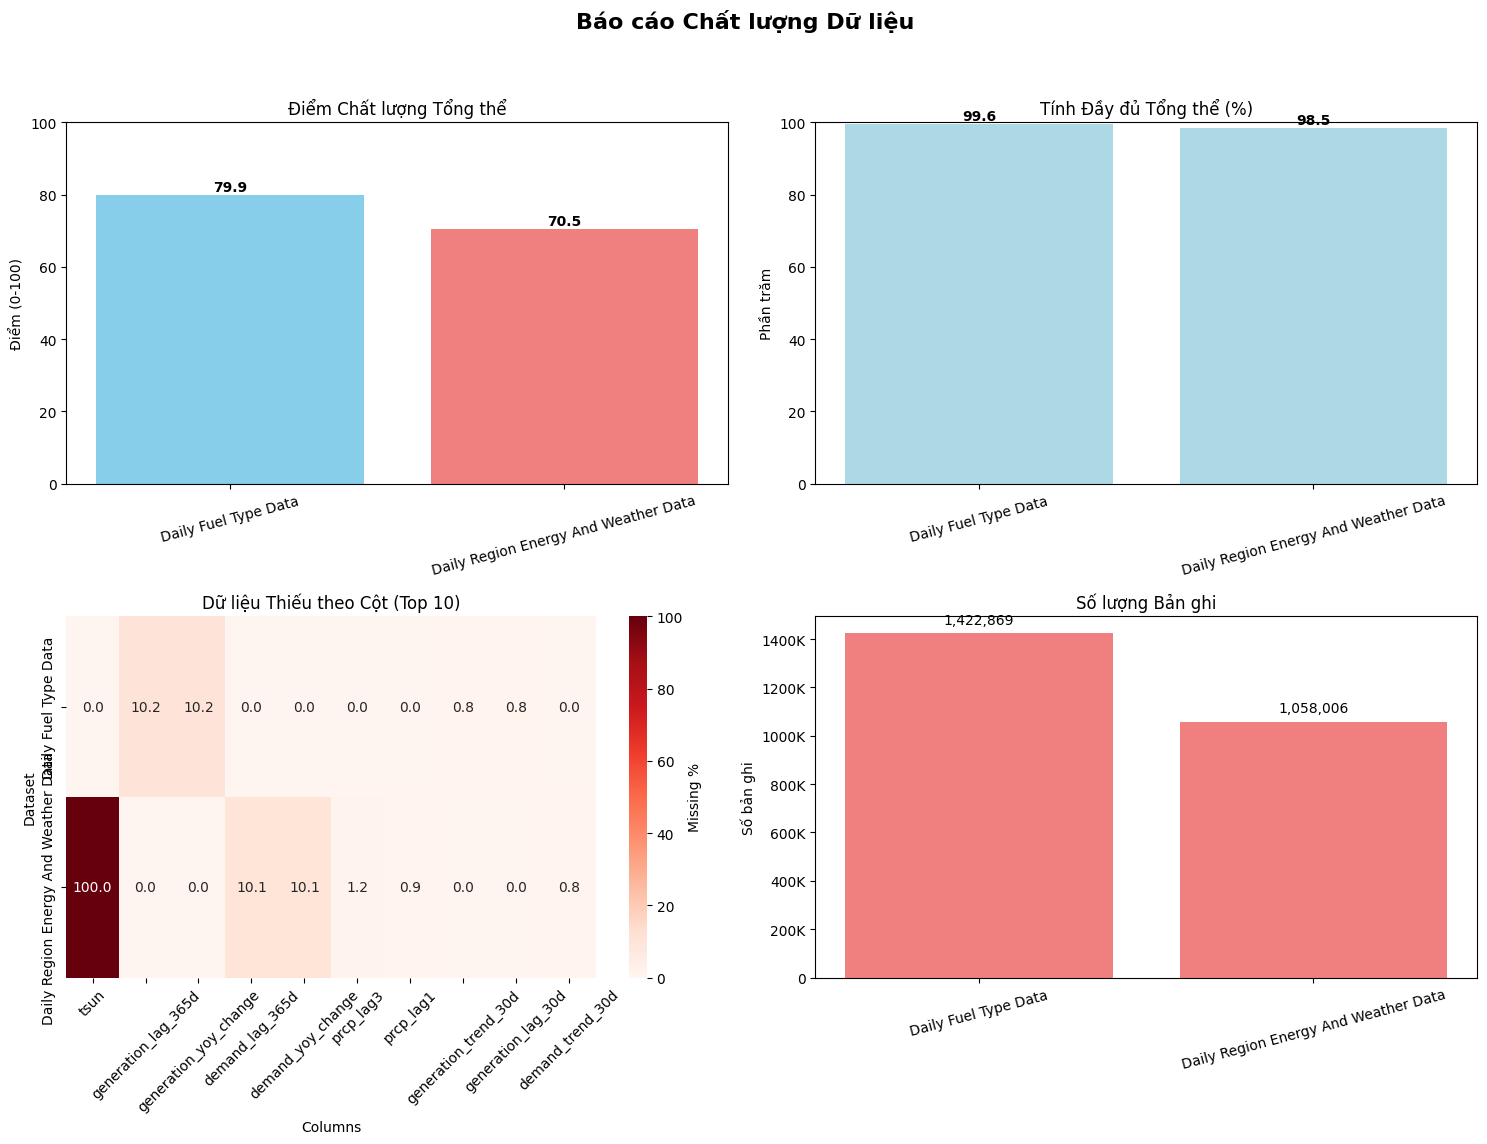

\n🔍 3. PHÂN TÍCH CHI TIẾT:
\n📊 Dataset: Daily Fuel Type Data
--------------------------------------------------
⚠️ Các vấn đề phát hiện:
   - Thiếu dữ liệu nghiêm trọng (89.8% hoàn chỉnh)
   - Có 33,156 giá trị âm
   - Nhiều giá trị cực đoan (15,084)
💡 Khuyến nghị xử lý:
   - Xem xét loại bỏ hoặc điền các cột thiếu nhiều dữ liệu: ['generation_lag_365d', 'generation_yoy_change']
   - Kiểm tra và xử lý các giá trị cực đoan (outliers)

\n📊 Dataset: Daily Region Energy And Weather Data
--------------------------------------------------
⚠️ Các vấn đề phát hiện:
   - Thiếu dữ liệu nghiêm trọng (0.0% hoàn chỉnh)
   - Có 155,130 giá trị âm
   - Nhiều giá trị cực đoan (10,965)
💡 Khuyến nghị xử lý:
   - Xem xét loại bỏ hoặc điền các cột thiếu nhiều dữ liệu: ['demand_lag_365d', 'demand_yoy_change', 'tsun']
   - Kiểm tra và xử lý các giá trị cực đoan (outliers)

💾 4. XUẤT BÁO CÁO:
📄 Đã xuất báo cáo chất lượng ra file: data_quality_report_20250630_080617.txt
📄 Đã lưu bảng so sánh: data_quality_comp

In [ ]:
# Tạo báo cáo so sánh và trực quan hóa kết quả

print("📊 TẠO BÁO CÁO SO SÁNH CHẤT LƯỢNG DỮ LIỆU")
print("=" * 80)

if assessment_results:
    # 1. Tạo bảng so sánh tổng quan
    print("\\n📋 1. BẢNG SO SÁNH TỔNG QUAN:")
    comparison_data = []

    for dataset_name, result in assessment_results.items():
        row = {
            'Dataset': dataset_name,
            'Records': f"{result['total_records']:,}",
            'Columns': result['total_columns'],
            'Size_MB': f"{result['basic_info']['memory_usage_mb']:.2f}",
        }

        if 'overall_score' in result:
            row['Overall_Score'] = f"{result['overall_score'].get('overall', 0):.1f}"
            row['Completeness'] = f"{result['overall_score'].get('completeness', 0):.1f}"
            row['Accuracy'] = f"{result['overall_score'].get('accuracy', 0):.1f}"

        if 'completeness' in result:
            missing_cols = sum(1 for v in result['completeness']['missing_percent'].values() if v > 0)
            row['Missing_Columns'] = missing_cols

        if 'uniqueness' in result:
            row['Duplicates'] = f"{result['uniqueness']['duplicate_percent']:.2f}%"

        comparison_data.append(row)

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    # 2. Trực quan hóa kết quả
    print("\\n📈 2. TRỰC QUAN HÓA KẾT QUẢ:")
    quality_assessor.visualize_quality_report()

    # 3. Phân tích chi tiết từng dataset
    print("\\n🔍 3. PHÂN TÍCH CHI TIẾT:")

    for dataset_name, result in assessment_results.items():
        print(f"\\n📊 Dataset: {dataset_name}")
        print("-" * 50)

        # Vấn đề chất lượng dữ liệu
        issues = []

        if 'completeness' in result:
            missing_percent = result['completeness']['complete_rows_percent']
            if missing_percent < 95:
                issues.append(f"Thiếu dữ liệu nghiêm trọng ({missing_percent:.1f}% hoàn chỉnh)")
            elif missing_percent < 99:
                issues.append(f"Thiếu dữ liệu nhẹ ({missing_percent:.1f}% hoàn chỉnh)")

        if 'uniqueness' in result:
            duplicate_percent = result['uniqueness']['duplicate_percent']
            if duplicate_percent > 5:
                issues.append(f"Nhiều bản ghi trùng lặp ({duplicate_percent:.1f}%)")
            elif duplicate_percent > 1:
                issues.append(f"Có bản ghi trùng lặp ({duplicate_percent:.1f}%)")

        if 'validity' in result:
            total_negative = sum(result['validity']['negative_values'].values())
            total_extreme = sum(result['validity']['extreme_values'].values())
            if total_negative > 0:
                issues.append(f"Có {total_negative:,} giá trị âm")
            if total_extreme > result['total_records'] * 0.01:  # > 1%
                issues.append(f"Nhiều giá trị cực đoan ({total_extreme:,})")

        if 'timeliness' in result:
            if 'gaps' in result['consistency'] and result['consistency']['gaps']:
                issues.append(f"Có khoảng trống thời gian")

        # Hiển thị vấn đề
        if issues:
            print("⚠️ Các vấn đề phát hiện:")
            for issue in issues:
                print(f"   - {issue}")
        else:
            print("✅ Không phát hiện vấn đề chất lượng nghiêm trọng")

        # Khuyến nghị
        recommendations = []

        if 'completeness' in result:
            missing_cols = [col for col, percent in result['completeness']['missing_percent'].items() if percent > 10]
            if missing_cols:
                recommendations.append(f"Xem xét loại bỏ hoặc điền các cột thiếu nhiều dữ liệu: {missing_cols[:3]}")

        if 'uniqueness' in result and result['uniqueness']['duplicate_percent'] > 1:
            recommendations.append("Loại bỏ các bản ghi trùng lặp")

        if 'validity' in result:
            total_extreme = sum(result['validity']['extreme_values'].values())
            if total_extreme > 0:
                recommendations.append("Kiểm tra và xử lý các giá trị cực đoan (outliers)")

        if recommendations:
            print("💡 Khuyến nghị xử lý:")
            for rec in recommendations:
                print(f"   - {rec}")

        print()

    # 4. Xuất báo cáo
    print("💾 4. XUẤT BÁO CÁO:")
    quality_assessor.export_quality_report()

    # Lưu bảng so sánh
    comparison_df.to_csv('data_quality_comparison.csv', index=False)
    print("📄 Đã lưu bảng so sánh: data_quality_comparison.csv")

    # 5. Tổng kết và đánh giá
    print("\\n🏆 5. TỔNG KẾT ĐÁNH GIÁ:")

    # Tính điểm trung bình
    overall_scores = []
    for result in assessment_results.values():
        if 'overall_score' in result and 'overall' in result['overall_score']:
            overall_scores.append(result['overall_score']['overall'])

    if overall_scores:
        avg_score = sum(overall_scores) / len(overall_scores)
        print(f"📊 Điểm chất lượng trung bình: {avg_score:.1f}/100")

        if avg_score >= 80:
            print("✅ Chất lượng dữ liệu tốt - Có thể sử dụng cho phân tích")
        elif avg_score >= 60:
            print("⚠️ Chất lượng dữ liệu trung bình - Cần xử lý một số vấn đề")
        else:
            print("❌ Chất lượng dữ liệu kém - Cần xử lý nghiêm túc trước khi sử dụng")

    print("\\n🔍 Recommendations for Data Quality Improvement:")
    print("1. 🧹 Data Cleaning: Xử lý missing values và outliers")
    print("2. 🔄 Data Validation: Kiểm tra business rules và constraints")
    print("3. 📊 Data Monitoring: Thiết lập monitoring cho quality metrics")
    print("4. 📝 Data Documentation: Tài liệu hóa schema và quality requirements")

else:
    print("❌ Không có kết quả đánh giá nào để hiển thị!")

print("\\n" + "=" * 80)
print("🎉 HOÀN THÀNH BÁO CÁO ĐÁNH GIÁ CHẤT LƯỢNG DỮ LIỆU!")

In [ ]:
# Hàm xử lý và làm sạch dữ liệu dựa trên kết quả đánh giá

class DataQualityProcessor:
    """
    Class xử lý và cải thiện chất lượng dữ liệu dựa trên kết quả đánh giá
    """

    def __init__(self, quality_report: dict):
        self.quality_report = quality_report

    def clean_dataset(self, df: pd.DataFrame, dataset_name: str,
                     auto_fix: bool = True, save_cleaned: bool = True) -> pd.DataFrame:
        """
        Làm sạch dữ liệu dựa trên kết quả đánh giá chất lượng

        Args:
            df: DataFrame cần làm sạch
            dataset_name: Tên dataset (phải có trong quality_report)
            auto_fix: Tự động sửa các vấn đề đơn giản
            save_cleaned: Lưu file đã làm sạch

        Returns:
            DataFrame đã được làm sạch
        """

        if dataset_name not in self.quality_report:
            print(f"❌ Không tìm thấy báo cáo chất lượng cho {dataset_name}")
            return df

        print(f"🧹 BẮT ĐẦU LÀM SẠCH DỮ LIỆU: {dataset_name}")
        print("=" * 60)

        df_cleaned = df.copy()
        report = self.quality_report[dataset_name]
        changes_made = []

        # 1. Xử lý duplicate records
        if 'uniqueness' in report and report['uniqueness']['total_duplicates'] > 0:
            initial_count = len(df_cleaned)
            df_cleaned = df_cleaned.drop_duplicates()
            removed_duplicates = initial_count - len(df_cleaned)

            if removed_duplicates > 0:
                changes_made.append(f"Loại bỏ {removed_duplicates:,} bản ghi trùng lặp")
                print(f"✅ Đã loại bỏ {removed_duplicates:,} bản ghi trùng lặp")

        # 2. Xử lý missing values
        if 'completeness' in report and auto_fix:
            missing_info = report['completeness']['missing_percent']

            for col, missing_percent in missing_info.items():
                if missing_percent > 50:
                    # Drop columns with >50% missing
                    if col in df_cleaned.columns:
                        df_cleaned = df_cleaned.drop(columns=[col])
                        changes_made.append(f"Loại bỏ cột '{col}' (thiếu {missing_percent:.1f}%)")
                        print(f"🗑️ Loại bỏ cột '{col}' do thiếu {missing_percent:.1f}% dữ liệu")

                elif missing_percent > 5 and missing_percent <= 50:
                    # Fill missing values
                    if col in df_cleaned.columns:
                        if df_cleaned[col].dtype in ['int64', 'float64']:
                            # Numeric columns - use median
                            median_val = df_cleaned[col].median()
                            df_cleaned[col].fillna(median_val, inplace=True)
                            changes_made.append(f"Điền giá trị median cho cột '{col}'")
                            print(f"🔢 Điền giá trị median ({median_val}) cho cột '{col}'")
                        else:
                            # Categorical columns - use mode
                            mode_val = df_cleaned[col].mode().iloc[0] if not df_cleaned[col].mode().empty else 'Unknown'
                            df_cleaned[col].fillna(mode_val, inplace=True)
                            changes_made.append(f"Điền giá trị mode cho cột '{col}'")
                            print(f"📝 Điền giá trị mode ('{mode_val}') cho cột '{col}'")

        # 3. Xử lý outliers
        if 'accuracy' in report and auto_fix:
            outliers_info = report['accuracy']['outliers_iqr']

            for col, outlier_count in outliers_info.items():
                if outlier_count > 0 and col in df_cleaned.columns:
                    if df_cleaned[col].dtype in ['int64', 'float64']:
                        # Sử dụng IQR method để xử lý outliers
                        Q1 = df_cleaned[col].quantile(0.25)
                        Q3 = df_cleaned[col].quantile(0.75)
                        IQR = Q3 - Q1
                        lower_bound = Q1 - 1.5 * IQR
                        upper_bound = Q3 + 1.5 * IQR

                        # Cap outliers instead of removing
                        initial_outliers = ((df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)).sum()

                        df_cleaned[col] = np.where(df_cleaned[col] < lower_bound, lower_bound, df_cleaned[col])
                        df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col])

                        if initial_outliers > 0:
                            changes_made.append(f"Chuẩn hóa {initial_outliers:,} outliers trong cột '{col}'")
                            print(f"📊 Chuẩn hóa {initial_outliers:,} outliers trong cột '{col}'")

        # 4. Xử lý data types
        if auto_fix:
            # Chuyển đổi các cột có vẻ như datetime
            for col in df_cleaned.columns:
                if 'date' in col.lower() or 'time' in col.lower() or col.lower() == 'period':
                    try:
                        df_cleaned[col] = pd.to_datetime(df_cleaned[col])
                        changes_made.append(f"Chuyển đổi cột '{col}' sang datetime")
                        print(f"📅 Chuyển đổi cột '{col}' sang datetime")
                    except:
                        pass

                # Chuyển đổi các cột numeric
                elif col.lower() in ['value', 'amount', 'price', 'quantity']:
                    try:
                        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
                        changes_made.append(f"Chuyển đổi cột '{col}' sang numeric")
                        print(f"🔢 Chuyển đổi cột '{col}' sang numeric")
                    except:
                        pass

        # 5. Xử lý negative values (nếu không hợp lệ cho business logic)
        if 'validity' in report and auto_fix:
            negative_values = report['validity']['negative_values']

            for col, neg_count in negative_values.items():
                if neg_count > 0 and col in df_cleaned.columns:
                    # Với dữ liệu điện năng, giá trị âm có thể không hợp lệ
                    if col.lower() in ['value', 'demand', 'generation', 'consumption']:
                        # Chuyển giá trị âm thành 0 hoặc absolute value
                        negative_mask = df_cleaned[col] < 0
                        df_cleaned.loc[negative_mask, col] = df_cleaned.loc[negative_mask, col].abs()

                        if neg_count > 0:
                            changes_made.append(f"Chuyển {neg_count:,} giá trị âm thành dương trong cột '{col}'")
                            print(f"🔄 Chuyển {neg_count:,} giá trị âm thành dương trong cột '{col}'")

        # Tóm tắt các thay đổi
        print(f"\\n📋 TÓM TẮT CÁC THAY ĐỔI:")
        if changes_made:
            for i, change in enumerate(changes_made, 1):
                print(f"   {i}. {change}")
        else:
            print("   ✅ Không cần thay đổi nào")

        print(f"\\n📊 KẾT QUẢ LÀM SẠCH:")
        print(f"   - Trước: {len(df):,} hàng × {len(df.columns)} cột")
        print(f"   - Sau: {len(df_cleaned):,} hàng × {len(df_cleaned.columns)} cột")

        # Lưu file đã làm sạch
        if save_cleaned:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            clean_filename = f"{dataset_name.lower().replace(' ', '_')}_cleaned_{timestamp}.csv"
            df_cleaned.to_csv(clean_filename, index=False)
            print(f"💾 Đã lưu dữ liệu sạch: {clean_filename}")

        print("=" * 60)
        return df_cleaned

    def create_cleaning_plan(self, dataset_name: str) -> dict:
        """
        Tạo kế hoạch làm sạch dữ liệu chi tiết
        """
        if dataset_name not in self.quality_report:
            return {}

        report = self.quality_report[dataset_name]
        plan = {
            'dataset': dataset_name,
            'actions': [],
            'priority': 'medium',
            'estimated_time': 'short'
        }

        # Phân tích mức độ ưu tiên
        issues_count = 0

        if 'uniqueness' in report and report['uniqueness']['duplicate_percent'] > 5:
            plan['actions'].append("HIGH: Loại bỏ duplicate records")
            issues_count += 1

        if 'completeness' in report and report['completeness']['complete_rows_percent'] < 80:
            plan['actions'].append("HIGH: Xử lý missing values nghiêm trọng")
            issues_count += 1

        if 'validity' in report:
            total_invalid = sum(report['validity']['negative_values'].values())
            if total_invalid > report['total_records'] * 0.1:
                plan['actions'].append("MEDIUM: Xử lý giá trị không hợp lệ")
                issues_count += 1

        if 'accuracy' in report:
            total_outliers = sum(report['accuracy']['outliers_iqr'].values())
            if total_outliers > report['total_records'] * 0.05:
                plan['actions'].append("MEDIUM: Xử lý outliers")

        # Xác định mức độ ưu tiên tổng thể
        if issues_count >= 2:
            plan['priority'] = 'high'
            plan['estimated_time'] = 'long'
        elif issues_count == 1:
            plan['priority'] = 'medium'
            plan['estimated_time'] = 'medium'
        else:
            plan['priority'] = 'low'
            plan['estimated_time'] = 'short'

        return plan

# Demo sử dụng Data Quality Processor
if assessment_results:
    print("🔧 DEMO: SỬ DỤNG DATA QUALITY PROCESSOR")
    print("=" * 60)

    # Tạo processor
    processor = DataQualityProcessor(assessment_results)

    # Tạo kế hoạch làm sạch cho từng dataset
    for dataset_name in assessment_results.keys():
        print(f"\\n📋 Kế hoạch làm sạch cho {dataset_name}:")
        plan = processor.create_cleaning_plan(dataset_name)

        print(f"   🎯 Ưu tiên: {plan['priority'].upper()}")
        print(f"   ⏱️ Thời gian ước tính: {plan['estimated_time']}")

        if plan['actions']:
            print(f"   📝 Các hành động:")
            for action in plan['actions']:
                print(f"      - {action}")
        else:
            print(f"   ✅ Không cần hành động đặc biệt")

    print(f"\\n💡 Để làm sạch dữ liệu, sử dụng:")
    print(f"   processor.clean_dataset(df, 'dataset_name', auto_fix=True)")

else:
    print("⚠️ Chưa có kết quả đánh giá để tạo processor")

print("\\n✅ Data Quality Processor đã sẵn sàng!")

🔧 DEMO: SỬ DỤNG DATA QUALITY PROCESSOR
\n📋 Kế hoạch làm sạch cho Daily Fuel Type Data:
   🎯 Ưu tiên: LOW
   ⏱️ Thời gian ước tính: short
   📝 Các hành động:
      - MEDIUM: Xử lý outliers
\n📋 Kế hoạch làm sạch cho Daily Region Energy And Weather Data:
   🎯 Ưu tiên: HIGH
   ⏱️ Thời gian ước tính: long
   📝 Các hành động:
      - HIGH: Xử lý missing values nghiêm trọng
      - MEDIUM: Xử lý giá trị không hợp lệ
      - MEDIUM: Xử lý outliers
\n💡 Để làm sạch dữ liệu, sử dụng:
   processor.clean_dataset(df, 'dataset_name', auto_fix=True)
\n✅ Data Quality Processor đã sẵn sàng!


In [ ]:
processor.clean_dataset(df, 'Daily Fuel Type Data', auto_fix=True)

🧹 BẮT ĐẦU LÀM SẠCH DỮ LIỆU: Daily Fuel Type Data
📊 Chuẩn hóa 136,887 outliers trong cột 'value'
📅 Chuyển đổi cột 'period' sang datetime
🔢 Chuyển đổi cột 'value' sang numeric
📅 Chuyển đổi cột 'date' sang datetime
📅 Chuyển đổi cột 'time' sang datetime
🔄 Chuyển 33,156 giá trị âm thành dương trong cột 'value'
\n📋 TÓM TẮT CÁC THAY ĐỔI:
   1. Chuẩn hóa 136,887 outliers trong cột 'value'
   2. Chuyển đổi cột 'period' sang datetime
   3. Chuyển đổi cột 'value' sang numeric
   4. Chuyển đổi cột 'date' sang datetime
   5. Chuyển đổi cột 'time' sang datetime
   6. Chuyển 33,156 giá trị âm thành dương trong cột 'value'
\n📊 KẾT QUẢ LÀM SẠCH:
   - Trước: 1,058,006 hàng × 84 cột
   - Sau: 1,058,006 hàng × 84 cột
💾 Đã lưu dữ liệu sạch: daily_fuel_type_data_cleaned_20250630_080618.csv


,period,respondent,respondent-name,type,type-name,timezone,timezone-description,value,value-units,year,...,prcp_lag3,prcp_ma7,wspd_lag1,wspd_lag3,wspd_ma7,discomfort_index,heat_stress,cooling_demand_factor,heating_demand_factor,weather_severity_index
0,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Arizona,Arizona,14161.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
1,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Central,Central,14023.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
2,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Eastern,Eastern,13960.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
3,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Mountain,Mountain,14103.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
4,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Pacific,Pacific,14161.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058001,2022-06-01,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",TI,Total interchange,Arizona,Arizona,4083.0,megawatthours,2022,...,0.0,2.728571,8.7,5.8,8.914286,61.096,0.0,0.013158,0.000000,0
1058002,2022-06-01,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",TI,Total interchange,Central,Central,4082.0,megawatthours,2022,...,0.0,2.728571,8.7,5.8,8.914286,61.096,0.0,0.013158,0.000000,0
1058003,2022-06-01,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",TI,Total interchange,Eastern,Eastern,4082.0,megawatthours,2022,...,0.0,2.728571,8.7,5.8,8.914286,61.096,0.0,0.013158,0.000000,0
1058004,2022-06-01,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",TI,Total interchange,Mountain,Mountain,4083.0,megawatthours,2022,...,0.0,2.728571,8.7,5.8,8.914286,61.096,0.0,0.013158,0.000000,0


In [ ]:
processor.clean_dataset(df, 'Daily Region Energy And Weather Data', auto_fix=True)

🧹 BẮT ĐẦU LÀM SẠCH DỮ LIỆU: Daily Region Energy And Weather Data
🔢 Điền giá trị median (38229.0) cho cột 'demand_lag_365d'
🔢 Điền giá trị median (-173.0) cho cột 'demand_yoy_change'
🗑️ Loại bỏ cột 'tsun' do thiếu 100.0% dữ liệu
📊 Chuẩn hóa 136,887 outliers trong cột 'value'
📅 Chuyển đổi cột 'period' sang datetime
🔢 Chuyển đổi cột 'value' sang numeric
📅 Chuyển đổi cột 'date' sang datetime
📅 Chuyển đổi cột 'time' sang datetime
🔄 Chuyển 155,130 giá trị âm thành dương trong cột 'value'
\n📋 TÓM TẮT CÁC THAY ĐỔI:
   1. Điền giá trị median cho cột 'demand_lag_365d'
   2. Điền giá trị median cho cột 'demand_yoy_change'
   3. Loại bỏ cột 'tsun' (thiếu 100.0%)
   4. Chuẩn hóa 136,887 outliers trong cột 'value'
   5. Chuyển đổi cột 'period' sang datetime
   6. Chuyển đổi cột 'value' sang numeric
   7. Chuyển đổi cột 'date' sang datetime
   8. Chuyển đổi cột 'time' sang datetime
   9. Chuyển 155,130 giá trị âm thành dương trong cột 'value'
\n📊 KẾT QUẢ LÀM SẠCH:
   - Trước: 1,058,006 hàng × 84 cột


,period,respondent,respondent-name,type,type-name,timezone,timezone-description,value,value-units,year,...,prcp_lag3,prcp_ma7,wspd_lag1,wspd_lag3,wspd_ma7,discomfort_index,heat_stress,cooling_demand_factor,heating_demand_factor,weather_severity_index
0,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Arizona,Arizona,14161.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
1,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Central,Central,14023.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
2,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Eastern,Eastern,13960.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
3,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Mountain,Mountain,14103.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
4,2020-06-01,AEC,PowerSouth Energy Cooperative,D,Demand,Pacific,Pacific,14161.0,megawatthours,2020,...,NaN,0.000000,NaN,NaN,8.500000,60.088,0.0,0.000000,0.016349,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058001,2022-06-01,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",TI,Total interchange,Arizona,Arizona,4083.0,megawatthours,2022,...,0.0,2.728571,8.7,5.8,8.914286,61.096,0.0,0.013158,0.000000,0
1058002,2022-06-01,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",TI,Total interchange,Central,Central,4082.0,megawatthours,2022,...,0.0,2.728571,8.7,5.8,8.914286,61.096,0.0,0.013158,0.000000,0
1058003,2022-06-01,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",TI,Total interchange,Eastern,Eastern,4082.0,megawatthours,2022,...,0.0,2.728571,8.7,5.8,8.914286,61.096,0.0,0.013158,0.000000,0
1058004,2022-06-01,YAD,"Alcoa Power Generating, Inc. - Yadkin Division",TI,Total interchange,Mountain,Mountain,4083.0,megawatthours,2022,...,0.0,2.728571,8.7,5.8,8.914286,61.096,0.0,0.013158,0.000000,0
